In [373]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

learning_rate = 0.1
discount_factor = 0.99
EPSILON = 1
epsilon_decay_rate = 0.8
min_epsilon = 0.01
epochs = 5000

theta_bins = [-12 * np.pi / 180, -6 * np.pi / 180, -1 * np.pi / 180, 0, 1 * np.pi / 180, 6 * np.pi / 180, 12 * np.pi / 180]
x_bins = [-2.4, -0.8, 0.8, 2.4]
theta_dot_bins = [-np.inf, -50 * np.pi / 180, 50 * np.pi / 180, np.inf]
x_dot_bins = [-np.inf, -0.5, 0.5, np.inf]


M = 1.0  # Mass of the cart
m = 0.1  # Mass of the pole
g = -9.8  # Gravity
l = 0.5  # Length of the pole
mu_c = 0.0005  # Friction for the cart
mu_p = 0.000002  # Friction for the pole
delta_t = 0.02  # Time step
force = 10 # force


# Q (theta, x, theta_dot, x_dot, 动作)
Q = np.random.uniform(low=-1, high=1, size=(len(theta_bins)-1, len(x_bins)-1, len(theta_dot_bins)-1, len(x_dot_bins)-1, 2))


In [389]:
def discretize_state(state):
    theta, x, theta_dot, x_dot = state
    theta_idx = np.digitize(theta, theta_bins) - 1
    x_idx = np.digitize(x, x_bins) - 1
    theta_dot_idx = np.digitize(theta_dot, theta_dot_bins) - 1
    x_dot_idx = np.digitize(x_dot, x_dot_bins) - 1
    
    
    theta_idx = np.clip(theta_idx, 0, len(theta_bins) - 2)
    x_idx = np.clip(x_idx, 0, len(x_bins) - 2)
    theta_dot_idx = np.clip(theta_dot_idx, 0, len(theta_dot_bins) - 2)
    x_dot_idx = np.clip(x_dot_idx, 0, len(x_dot_bins) - 2)
    
    return theta_idx, x_idx, theta_dot_idx, x_dot_idx

def isTerminal(state, time):
    theta, x, theta_dot, x_dot = state
    if abs(theta) > (12*np.pi/180) or abs(x) > 2.4 or time > 200:
        return True
    else:
        return False
    
def extra_reward(state):
    theta, x, theta_dot, x_dot = state
    if abs(theta) < (6*np.pi/180) or abs(x) < 0.8:
        return 10
    else:
        return 0
    
def compute_accelerations(theta, theta_dot, x_dot, F):
    """Compute angular and linear accelerations based on the model."""
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    theta_ddot = (g * sin_theta + cos_theta * ((-F - m * l * (theta_dot**2) * sin_theta + mu_c * np.sign(x_dot)) / (M + m)) - (mu_p * theta_dot / (m * l))) / (l * (4 / 3 - m * cos_theta**2 / (M + m)))
    x_ddot = (F + m * l * (theta_dot**2 * sin_theta - theta_ddot * cos_theta) - mu_c * np.sign(x_dot)) / (M + m)
    
    return theta_ddot, x_ddot

def update_state(state, force):
    """Update the state using Euler integration"""
    theta, theta_dot, x, x_dot = state  # state s = (theta, theta_dot, x, x_dot)
    F = force
    theta_ddot, x_ddot = compute_accelerations(theta, theta_dot, x_dot, F)
    x_dot += delta_t * x_ddot  # update x_dot
    x += delta_t * x_dot  # update x
    theta_dot += delta_t * theta_ddot  # update theta_dot
    theta += delta_t * theta_dot  # update theta
    
    return np.array([theta, theta_dot, x, x_dot])

def train():
    rewards = []
    for episode in range(epochs):
        state_raw = np.array([
            np.random.uniform(-12*np.pi/180, 12*np.pi/180),  # theta
            np.random.uniform(-2.4, 2.4),                   # x
            np.random.uniform(-1*np.pi/180, 1*np.pi/180),                       # theta_dot
            np.random.uniform(-1, 1)                        # x_dot
        ])  # Initial state
        
        
        state_raw = np.zeros(4)
        
        
        state = discretize_state(state_raw)
        done = False
        total_reward = 0
        time = 0
        epsilon = EPSILON

        while not done:
            # epsilon-greedy
            epsilon = max(epsilon_decay_rate*epsilon, min_epsilon)
            if random.uniform(0, 1) < epsilon:
                action = np.random.binomial(1, 0.5)
            else:
                action = np.argmax(Q[state])
            
            force = action*20 - 10
            next_state_raw = update_state(state_raw,force)
            done = isTerminal(next_state_raw,time)
            if done == True:
                reward = 0
            else:
                reward = 1
    
            next_state = discretize_state(next_state_raw)
            
            # update Q
            if not done:
                Q[state][action] = Q[state][action] + learning_rate * (
                    reward + extra_reward(next_state_raw) + discount_factor * np.max(Q[next_state]) - Q[state][action]
                )
            else:
                Q[state][action] = Q[state][action] + learning_rate * (
                    reward - Q[state][action]
                )

            state = next_state
            state_raw = next_state_raw
            total_reward += reward
            time += 1


        rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{epochs}, Average reward: {np.average(rewards[episode-99:episode+1])}")

    return rewards


def test():
    state = discretize_state(np.random.uniform(low=-np.pi/10, high=np.pi/10, size=4))  # Initial state
    if isinstance(state, dict):
        state = state['state']
    state = discretize_state(state)
    done = False
    total_reward = 0

    while not done:
        action = np.argmax(Q[state])  
        next_state, reward, done, _, _ = env.step(action)
        if isinstance(next_state, dict):
            next_state = next_state['state']
        next_state = discretize_state(next_state)
        state = next_state
        total_reward += reward

    print(f"Test Total Reward: {total_reward}")

In [390]:
rewards = train()

Episode 100/5000, Average reward: 190.76
Episode 200/5000, Average reward: 194.61
Episode 300/5000, Average reward: 200.02
Episode 400/5000, Average reward: 184.26
Episode 500/5000, Average reward: 181.56
Episode 600/5000, Average reward: 188.28
Episode 700/5000, Average reward: 190.1
Episode 800/5000, Average reward: 188.03
Episode 900/5000, Average reward: 197.49
Episode 1000/5000, Average reward: 191.05
Episode 1100/5000, Average reward: 180.14
Episode 1200/5000, Average reward: 190.25
Episode 1300/5000, Average reward: 191.64
Episode 1400/5000, Average reward: 190.6
Episode 1500/5000, Average reward: 192.61
Episode 1600/5000, Average reward: 195.5
Episode 1700/5000, Average reward: 188.91
Episode 1800/5000, Average reward: 183.06
Episode 1900/5000, Average reward: 174.0
Episode 2000/5000, Average reward: 188.93
Episode 2100/5000, Average reward: 187.15
Episode 2200/5000, Average reward: 175.63
Episode 2300/5000, Average reward: 193.8
Episode 2400/5000, Average reward: 177.5
Episode

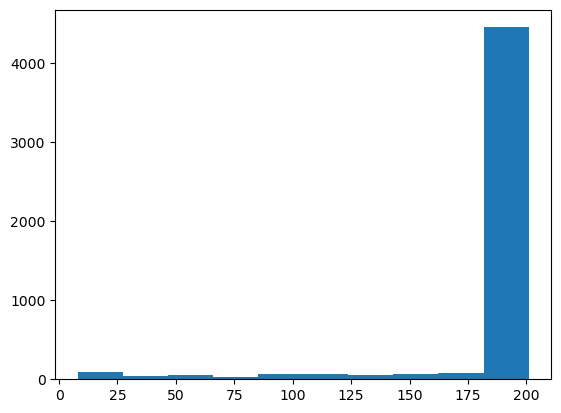

In [391]:
plt.hist(rewards)
plt.show()

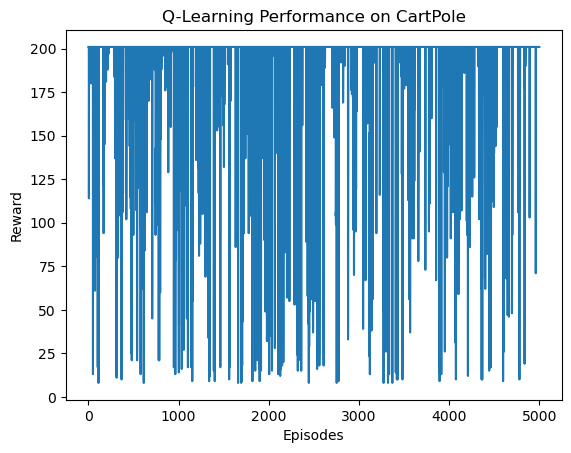

In [392]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Q-Learning Performance on CartPole')
plt.show()

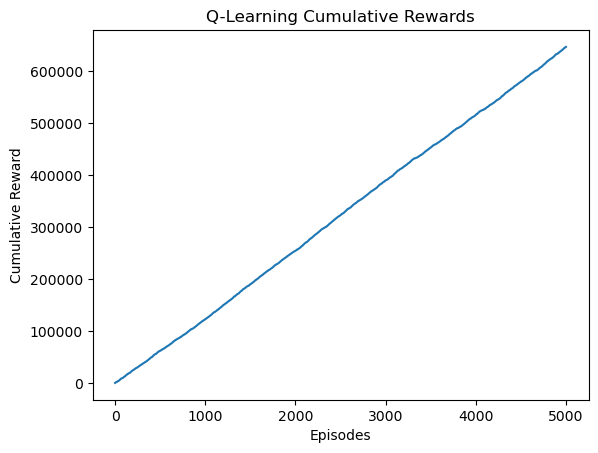

In [387]:
cumulative_rewards = []
for reward in rewards:
    if len(cumulative_rewards) == 0:
        cumulative_rewards.append(reward)
    else:
        cumulative_rewards.append(cumulative_rewards[-1] + reward)
        
plt.plot(cumulative_rewards)
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning Cumulative Rewards')
plt.show()